# **Keras implementation of Show and Tell model**

----

Re-implementation of the **Show and Tell model** in Keras. 

Image encoder - State of the art models for image classification - InceptionV3. 

For language encoders, GRUs are used along to extract features from the text.

#### Importing the required packages

In [1]:
!nvidia-smi

Wed Oct 28 15:21:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import cv2
import os
import numpy as np 
import random
from collections import Counter

from keras.callbacks import ReduceLROnPlateau, TensorBoard

%load_ext tensorboard

#### Creating requirements.txt

In [ ]:
!pip install pipreqsnb
!pipreqsnb --savepath 'requirements.txt' '/content/drive/My Drive/Colab Notebooks/ImageCaptioning_Show&Tell.ipynb'

pipreqs  --savepath requirements.txt .//__temp_pipreqsnb_folder/
INFO: Successfully saved requirements file in requirements.txt


#### Loading annotations and pre-processing it

In [3]:
main_dir = '/content/drive/My Drive/ImageCaptioning/'

In [4]:
#### LOADING ANNOTATIONS FILE, PREPROCESSING IT AND SAVING IT AS 'DESCRIPTIONS.TXT
def load_doc(filename):
	"""
	function to load the annotations file

	Parameters
	-------------
	filename: str
		full path of the annotations file
	
	Returns
	-------------
	text: list
		list of the annotations. i.e filename \t caption

	"""
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

# extract descriptions for images
def load_descriptions(doc):
	"""
	functions to map the captions to the image names

	Parameters
	--------------
	doc: list
		list of the annotations. i.e filename \t caption.
	
	Returns
	--------------
	mapping: dict
		Dictionary of the mapped captions to the image ids.

	"""
	mapping = dict()
	
	# Looping through the lines of the annotations.
	for line in doc.split('\n'):
		# Splitting the image id and the caption.
		tokens = line.strip().split('\t')
  
		if len(line) < 2:
			continue

		image_id, image_desc = tokens[0], tokens[1]

		# Removing the file extension from the image_id  
		image_id = image_id.split('.')[0]

		# checking if the mapping is already present.
		if image_id not in mapping:
			mapping[image_id] = image_desc

	return mapping

def clean_descriptions(descriptions):
	"""
	function to clean the descriptions, and filter the invalid words

	Parameters
	-------------
	descriptions: dict
		Dictionary of the mapped captions to the image ids.
	
	Returns
	-------------
	descriptions: dict
		Dictionary of the mapped cleaned captions to the image ids.

	"""
	SYMBOLS = "{}()[].,:;+*/&|<>=~$1234567890"

	# Looping through the dictionary items
	for key, desc in descriptions.items():

		# Splitting the words in the caption
		desc = desc.split()
		# Converting them to lower case
		desc = [word.lower() for word in desc]
		# Including words whose length is greater than 1
		desc = [word for word in desc if len(word)>1]
		# Removing the words which has symbols included and replacing them with [UNK] token.
		desc = [word if not any([char for char in word if char in SYMBOLS]) else '[UNK]' for word in desc]
		# Mapping the string caption to the 
		descriptions[key] =  "[STR] " + ' '.join(desc) + " [END]" 

	return descriptions

# save descriptions to file, one per line
def save_doc(descriptions, filename):
	"""
	function to save the cleaned descriptions

	Parameters
	-----------
	descriptions: dict
		Mapping dictionary of the cleaned captions to the image ids.
	
	filename: str
		Full path of the file, in which the cleaned captions are to be stored

	"""
	lines = list()
	for key, desc in descriptions.items():
		lines.append(key + '\t' + desc)
  
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

filename = main_dir + 'annotations_ajio_v4_full(2).txt'

doc = load_doc(filename)
print('Finished loading', filename)

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

descriptions = clean_descriptions(descriptions)
print("Finished cleaning descriptions")

all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))

#save_doc(descriptions, main_dir+'descriptions_v2.txt')
#print("Saving the doc to", main_dir+'descriptions_v2.txt)


Finished loading /content/drive/My Drive/ImageCaptioning/annotations_ajio_v4_full(2).txt
Loaded: 39000 
Finished cleaning descriptions
Vocabulary Size: 3446


In [5]:
print(list(descriptions.values())[0])

[STR] reptilian print bomber jacket [END]


#### Pre-processing captions for finding the **vocab_size** and **max_length_caption**

In [5]:
### PREPROCESSING CAPTIONS FOR TRAINING
def load_captions(descriptions):
    """
    function to append [STR] ( start token ) and [END] ( end token ) to the caption

    Parameters
    -----------------
    descriptions: dict
        mapped dictionary of the cleaned descriptions to the image id
    
    Returns
    -----------------
    captions: list
        list of all the captions with the tokens appended.

    """
    captions=[]
    for image_id in descriptions.keys():
        captions.append(descriptions[image_id])
    
    return captions

captions = load_captions(descriptions)
print(captions[0])

[STR] reptilian print bomber jacket [END]


In [6]:

# Creating a corpus of all the words in the descriptions
corpus = []
for caption in captions:
    for token in caption.split():
        corpus.append(token)
        
# Only including words if frequency is greater than 1.
hash_map = Counter(corpus)
vocab = []

for token,count in hash_map.items():
        vocab.append(token)

vocab.append('[PAD]')  
vocab.append('[UNK]')
vocab = sorted(vocab)
print('Number of original tokens',len(hash_map))
print('Number of tokens after threshold',len(vocab))

vocab_size = len(vocab) # one for appended 0's

# Finding out the maximum length of the captions

def max_len_caption(all_train_captions):   
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption= ',max_len)
    return max_len

final_length_caption = max_len_caption(captions)

word_to_index = dict()
index_to_word = dict()

for idx, word in enumerate(vocab):
    word_to_index[word] = idx
    index_to_word[idx] = word

Number of original tokens 3446
Number of tokens after threshold 3448
Maximum length of caption=  13


#### Shuffling and splitting the data to training, validation and testing data.

In [7]:
product_ids = list(descriptions.keys())
for i in range(10):
    random.shuffle(product_ids)
train_product_ids = product_ids[:int(0.9*len(product_ids))]
random.shuffle(train_product_ids)
val_product_ids = product_ids[int(0.9*len(product_ids)):int(0.95*len(product_ids))]
random.shuffle(val_product_ids)
test_product_ids = product_ids[int(0.95*len(product_ids)):]
random.shuffle(test_product_ids)
print("Total data length - ", len(product_ids))
print("Training data length - ", len(train_product_ids))
print("Validation data length - ",len(val_product_ids))
print("Test data length - ",len(test_product_ids))

Total data length -  39000
Training data length -  35100
Validation data length -  1950
Test data length -  1950


#### Pre processing the images.

These cells have already been excuted and the pre-processed images are saved in the drive


In [ ]:
## UNZIPPING IMAGES
from zipfile import ZipFile

filename= main_dir+'images_v4_full(2) (1).zip'
print(filename)
zip = ZipFile(filename)
zip.extractall()

data_dir = '/content/images_v4_full(2)'
output_data_dir = '/content/drive/My Drive/ImageCaptioning/39K_preprocessed_images'


/content/drive/My Drive/ImageCaptioning/images_v4_full(2) (1).zip


In [ ]:
from keras.applications.inception_v3 import preprocess_input

if not os.path.exists(output_data_dir):
    os.mkdir(output_data_dir)

for j,i in enumerate(os.listdir(data_dir)):
    if j%1000 == 0:
        print(j)
    if not os.path.exists(os.path.join(output_data_dir, i)):
        try:
            image_name = os.path.join(data_dir, i)
            image = cv2.imread(image_name)
            image = cv2.resize(image, (400,400))
            cv2.imwrite( os.path.join(output_data_dir, i), image)

        except cv2.error as e:
            print(e)

0
1000
2000
3000
4000
5000
6000
7000
8000
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



#### Loading captions for the train, val datasets

In [8]:
def load_captions_dict( descriptions, product_ids):
    train_captions=dict()
    new_product_ids = []
    for i, image_id in enumerate(descriptions.keys()):
        if image_id in product_ids:
            sequence = []
            sequence += descriptions[image_id].strip().split(" ")
            train_captions[image_id]= sequence
            new_product_ids.append(image_id)

    return train_captions, new_product_ids

In [22]:
output_data_dir = '/content/drive/My Drive/ImageCaptioning/39K_preprocessed_images'

train_captions_dict,  train_product_ids = load_captions_dict(descriptions, train_product_ids)
print("Finished loading train annotations!")
val_captions_dict, val_product_ids = load_captions_dict( descriptions, val_product_ids)
print("Finished loading validation annotations!")

Finished loading train annotations!
Finished loading validation annotations!


#### Defining the keras dataloader

In [9]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from google.colab.patches import cv2_imshow

def data_generator(data_dir, captions_dict, max_length,
                             word_to_index, vocab_size, num_photos_per_batch=32):

    image_dir = data_dir
    X1, X2, y1, = list(), list(), list()
    n=0

    # loop for ever over images
    while 1:
        for key, desc in captions_dict.items():
            
            try:
                image_name = os.path.join(data_dir, key+'.jpg')

                image = cv2.imread(image_name)
                image = np.expand_dims(image, axis=0)
                image = preprocess_input(image)
                image = image.reshape(image.shape[1], image.shape[2], 3)
                seq = []
                for i in desc:
                    if i in word_to_index.keys():
                        seq.append(word_to_index[i])
                    else:
                        seq.append(word_to_index['[UNK]'])

                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]

                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, dtype='float64')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size )[0]
               
                    X1.append(image)
                    X2.append(in_seq)
                    y1.append(out_seq)
                
                    n+=1

                    if n==num_photos_per_batch:
                            
                        yield ([np.array(X1, dtype='float64'),
                                            np.array(X2, dtype='int')], np.array(y1, dtype='float64'))
            
                        X1, X2, y1 = list(), list(), list()
                        n=0

            except IndexError as e:
                continue


In [23]:
batch_size = 16

data_dir = '/content/images_v4_full(2)'
output_data_dir = '/content/drive/My Drive/ImageCaptioning/39K_preprocessed_images'

annotations = train_captions_dict

train_generator = data_generator(output_data_dir,annotations, final_length_caption,
                             word_to_index, vocab_size,  num_photos_per_batch = batch_size)

annotations = val_captions_dict

val_generator = data_generator(output_data_dir, annotations, final_length_caption,
                             word_to_index, vocab_size,  num_photos_per_batch = batch_size)


In [24]:
a = next(train_generator)
print(a[0][0].shape)
print(a[0][1].shape)
print(a[1].shape)

(16, 400, 400, 3)
(16, 13)
(16, 3448)


#### Defining the keras model
 
**V1** 

With ResNet50 model as the image feature extractor

In [ ]:
from keras.applications.resnet50 import ResNet50 ,preprocess_input
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout, Dense, Embedding, TimeDistributed, Concatenate, RepeatVector, Activation, Input
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam

img_size = (400,400,3)
pretrained_img_model = ResNet50(input_shape=img_size, weights = None, include_top=True)

# Repeat the image vector
img_input = pretrained_img_model.inputs[0]
img_output = pretrained_img_model.outputs[0]
img_output = RepeatVector(final_length_caption)(img_output)

language_input =  Input(shape=(final_length_caption,))
language_model = Embedding(vocab_size, 256, input_length=final_length_caption)(language_input)
language_model = GRU(128, return_sequences=True)(language_model)
language_model = TimeDistributed(Dense(128))(language_model)

merged = Concatenate(axis=-1)([img_output, language_model])

merged = GRU(256, return_sequences=False)(merged)
merged = Dense(vocab_size)(merged)
merged = Activation('softmax')(merged)
model = Model(inputs=[img_input, language_input], outputs=merged)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 406, 406, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 200, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

#### Defining the model

**V2**

With MobileNetV2 model as the image feature extractor.

In [19]:
from keras.applications.mobilenet_v2 import MobileNetV2 ,preprocess_input
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout, Dense, Embedding, TimeDistributed, Concatenate, RepeatVector, Activation, Input
from keras.callbacks import TensorBoard, ModelCheckpoint

img_size = (400,400,3)
pretrained_img_model = MobileNetV2(input_shape=img_size, weights = None, include_top=True)

# Repeat the image vector
img_input = pretrained_img_model.inputs[0]
img_output = pretrained_img_model.outputs[0]
img_output = RepeatVector(final_length_caption)(img_output)

language_input =  Input(shape=(final_length_caption,))
language_model = Embedding(vocab_size, 256, input_length=final_length_caption)(language_input)
language_model = GRU(128, return_sequences=True)(language_model)
language_model = TimeDistributed(Dense(128))(language_model)

merged = Concatenate(axis=-1)([img_output, language_model])

merged = GRU(256, return_sequences=False)(merged)
merged = Dense(vocab_size)(merged)
merged = Activation('softmax')(merged)
model = Model(inputs=[img_input, language_input], outputs=merged)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 401, 401, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 200, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

#### Plotting the model

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file=os.path.join(model_dir, 'model.png'), show_shapes=True)

#### Training the model

In [ ]:
model_dir = os.path.join(main_dir, 'SOTA_v2')
log_dir = os.path.join(main_dir, 'SOTA_v2','logs_v3')

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

if not os.path.exists(log_dir):
    os.mkdir(log_dir)


In [ ]:
# Creating tensorboard logs

%tensorboard --logdir '/content/drive/My Drive/ImageCaptioning/SOTA_v2/logs_v4'

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1,min_lr=1e-8, factor = 0.5)

#tensorboard = TensorBoard(log_dir=log_dir , write_graph=True, write_images=True)   

history = model.fit_generator(generator=train_generator, steps_per_epoch= len(train_captions_dict)//(2 * batch_size),
                              validation_data = val_generator, validation_steps = len(val_captions_dict) // batch_size,
                              epochs = 50, shuffle = True, callbacks=[reduce_lr])

#### Plotting the loss and accuracy curves.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


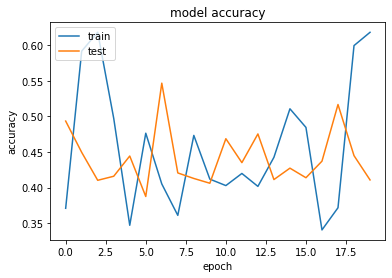

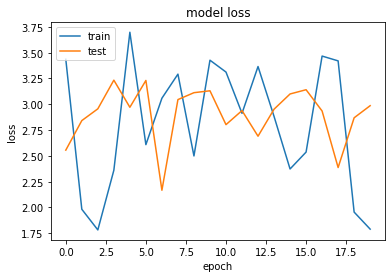

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Saving the model

In [ ]:
model.save(os.path.join(model_dir,'Show&Tell_50eps.h5'))

{'name': 'Adam', 'learning_rate': 1e-08, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [ ]:
import json

filename = os.path.join(model_dir,'Show&Tell_50eps.json')
f = open(filename,'w')
json.dump(word_to_index, f)
f.close()


#### Testing the model.

**Loading the model and the `word_to_index` dictionary**

In [10]:
# Loading the model

from keras.models import load_model
import json

model_dir = os.path.join(main_dir, 'exported_models')
model = load_model(os.path.join(model_dir,'Show&Tell_V1.h5'))

In [12]:
word_to_index = json.load(open(os.path.join(model_dir,'Show&Tell_vocab.json'), 'r'))
index_to_word = {idx:word for word,idx in word_to_index.items()}

**Loading the test data**



In [13]:
test_captions_dict , test_product_ids= load_captions_dict( descriptions, test_product_ids)
print("Finished loading test annotations!")

# Creating test generator
annotations = test_captions_dict
data_dir = '/content/drive/My Drive/ImageCaptioning/39K_preprocessed_images'

test_generator = data_generator(data_dir, annotations, final_length_caption,
                             word_to_index, vocab_size,  num_photos_per_batch = 1)

Finished loading test annotations!


In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def greedySearch(photo):
    in_text = '[STR]'
    photo = np.expand_dims(photo, axis=0)
    sequence = []
    for i in range(final_length_caption):
        sequence = [word_to_index[w] for w in in_text.split(' ') if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen = final_length_caption)[0]
        sequence = np.array(sequence).reshape(1, -1)
        yhat = model.predict([photo,sequence],verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text+=' '+word
        if word == '[END]':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

for i in range(30):
    img_name = os.path.join(data_dir, test_product_ids[i] + '.jpg')
    print(img_name)
    cv2_imshow(cv2.imread(img_name))

    result = greedySearch(cv2.imread(img_name))

    print("Actual output:"," ".join(test_captions_dict[test_product_ids[i]]))
    print("Predicted output:",result)
    print("                                         ")

/content/drive/My Drive/ImageCaptioning/39K_preprocessed_images/Women's Jackets_ajio_441001197_black.jpg
